In [1]:
import pickle
import os,sys
import numpy as np
from baseline.AKE.ake import AKE
from baseline.Kriging.kriging import OrdryKriging
from baseline.NMF.nmf import NMF
from baseline.ST_MVL.st_mvl import ST_MVL
import matplotlib.pyplot as plt
import pickle
from multiprocessing import Pool
import multiprocessing as mp
import time

In [2]:
with open('../tensor2.pkl','rb') as f:
    tensor_array = pickle.load(f)

with open('../new_indices.pkl','rb') as f:
    new_indices = pickle.load(f)

In [3]:
tensor_array = np.array(tensor_array)
tensor_array = tensor_array[new_indices]

In [6]:
def generate_missing_matrix(data_matrix,miss_ratio=0.1, pattern='MCAR', start_p='c'):
    origin  = data_matrix.copy()
    spatial_size = data_matrix.shape[0]
    temporal_size = data_matrix.shape[1]
    mask = np.ones_like(data_matrix)
    if pattern == 'MCAR':

        k = round(spatial_size*temporal_size*miss_ratio)
        ri = np.random.choice(spatial_size*temporal_size,k,replace=False)

    elif pattern == 'MAR':
        k = round(spatial_size*temporal_size*miss_ratio/2)
        ri1 = np.random.choice(spatial_size*temporal_size,k,replace=False)

        random_start = np.random.randint(0,temporal_size)
        ri2 = np.linspace(random_start,spatial_size*temporal_size-1,num=k)
        ri2 = ri2.astype(int)

        ri = np.append(ri1,ri2,0)
        # ri = ri2
        # print(ri1,ri2)
        # print(ri)

    elif pattern == "MNAR":
        if start_p == 'c':
            # constant start at #0
            k = round(spatial_size* temporal_size*miss_ratio)
            # ri = np.random.choice(spatial_size*temporal_size,k,replace=False)
            start = 0
            # print(k)
            # ri = np.arange(0,spatial_size*temporal_size,k-2)
            ri = np.linspace(0,spatial_size*temporal_size-1,num=k)
            ri = ri.astype(int)
            # print(ri)
            # print(ri.__len__())
        elif start_p == 'r':
             # random start at first row
            k = round(spatial_size* temporal_size*miss_ratio)
            # ri = np.random.choice(spatial_size*temporal_size,k,replace=False)
            start = 0
            # print(k)
            # ri = np.arange(0,spatial_size*temporal_size,k-2)
            random_start = np.random.randint(0,temporal_size)
            ri = np.linspace(random_start,spatial_size*temporal_size-1,num=k)
            ri = ri.astype(int)
            # print(ri)
            # print(ri.__len__())           pass
        else:
            raise NameError
    else:
        raise NameError
    origin.flat[ri] = 0
    mask.flat[ri] = 0
    return origin,mask
data_matrix,mask =generate_missing_matrix(tensor_array[0],0.2,'MCAR','r')

/tmp/ipykernel_38741/1726047996.py:4: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig = plt.figure()


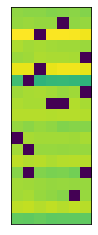

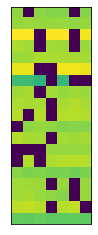

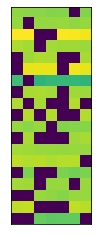

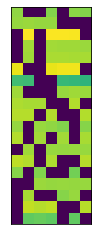

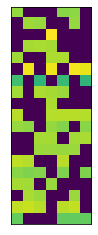

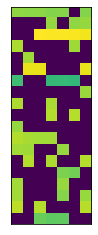

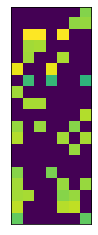

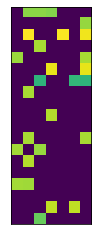

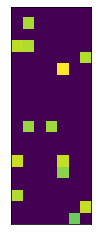

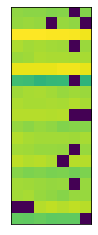

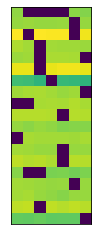

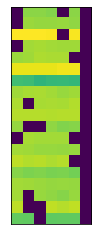

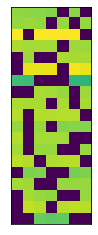

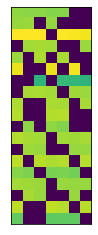

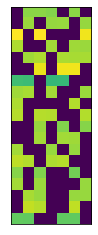

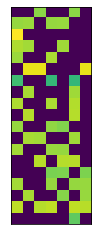

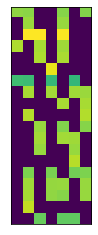

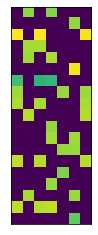

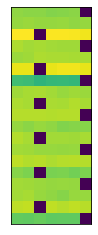

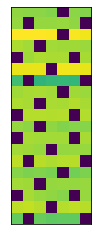

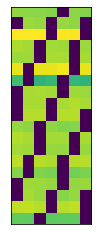

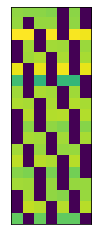

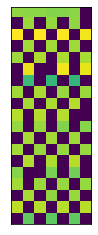

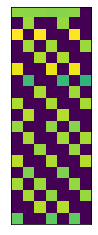

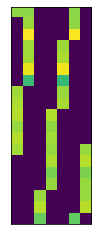

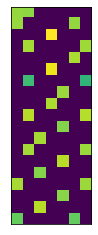

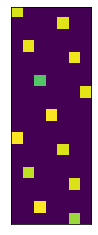

In [14]:
for pattern in ['MCAR','MAR','MNAR']:
    for i in np.arange(0.1,1,0.1):
        data_matrix,mask = generate_missing_matrix(tensor_array[0],i,pattern,'r')
        fig = plt.figure()
        # plt.title(''.format(i))
        fig = plt.imshow(data_matrix)
        fig.axes.get_xaxis().set_visible(False)
        fig.axes.get_yaxis().set_visible(False)
        plt.savefig('./missing_pattern/{}_{}.png'.format(pattern,i),dpi=300,bbox_inches='tight')

In [4]:
def get_distance_matrix(data_matrix,linear=False):
    if not linear:
        spatial_length = data_matrix.shape[0]
        # print(spatial_length)
        dis_matrix = np.random.rand(spatial_length,spatial_length)
        dis_matrix += dis_matrix.T
        np.fill_diagonal(dis_matrix,0)
        return dis_matrix
    else:
        spatial_length = data_matrix.shape[0]
        dis_matrix = np.zeros((spatial_length,spatial_length))
        for i in range(spatial_length):
            dis_matrix[i][i:] = np.arange(0,spatial_length-i)
        dis_matrix = dis_matrix + dis_matrix.T
        return dis_matrix

In [5]:
class Imputation_Result:
    missing_ratio = 0
    missing_pattern = ''
    missing_start_p = ''
    
    ake_loss = []
    kriging_loss = []
    nmf_loss = []
    st_mvl_loss = []


## Imputation

In [ ]:
def multi_process(missing_ratio):

    with open('../tensor2.pkl','rb') as f:
        tensor_array = pickle.load(f)

    with open('../new_indices.pkl','rb') as f:
        new_indices = pickle.load(f)

    tensor_array = np.array(tensor_array)
    tensor_array = tensor_array[new_indices]

    # print(missing_ratio)
    imputation_result_list = []
    # imputation_result = Imputation_Result()
    # imputation_result.missing_pattern='MCAR'
    # imputation_result.missing_ratio=missing_ratio
    # imputation_result_list.append(imputation_result)

    # imputation_result = Imputation_Result()
    # imputation_result.missing_pattern='MAR'
    # imputation_result.missing_ratio=missing_ratio
    # imputation_result_list.append(imputation_result)

    # imputation_result.missing_pattern='MNAR'
    # imputation_result.missing_ratio=missing_ratio
    # imputation_result_list.append(imputation_result)

    test_samples = 500

    for pattern in ['MCAR','MAR','MNAR']:
        if pattern == 'MNAR':
            start_p_list = ['c','r']
        else:
            start_p_list = ['r']

        for start_p in start_p_list:

            ake_loss = []
            kriging_loss = []
            nmf_loss = []
            st_mvl_loss = []  

            i = 0
            imputation_result = Imputation_Result()
            # imputation_result.missing_pattern=pattern
            imputation_result.missing_pattern= pattern
            imputation_result.missing_start_p = start_p
            imputation_result.missing_ratio=missing_ratio


            for tensor in tensor_array[:test_samples]:
                data_matrix,mask = generate_missing_matrix(tensor,missing_ratio,pattern,start_p)
                # print(data_matrix)
                # print('generated')

                ake = AKE()
                rec = ake.predict(data_matrix)
                ake_loss.append(np.sum(np.abs(rec-tensor)))
                # print('ake')

                odKrigin = OrdryKriging()
                odKrigin.train(data_matrix)
                rec1 = odKrigin.predict()
                kriging_loss.append(np.sum(np.abs(rec1-tensor)))
                # print('kri')

                nmf = NMF()
                rec2 = nmf.predict(data_matrix,mask)
                nmf_loss.append(np.sum(np.abs(rec2-tensor)))
                # print('nmf')

                stmvl = ST_MVL()
                ds = get_distance_matrix(data_matrix,True)
                rec3 = stmvl.predict(data_matrix,ds)
                st_mvl_loss.append(np.sum(np.abs(rec3-tensor)))
                # print('mvl')

                # print('miss_ratio:{}, i:{}, pattern:{}, start_p:{}'.format(missing_ratio,i,pattern,start_p))
                i += 1

            imputation_result.ake_loss = ake_loss
            imputation_result.kriging_loss = kriging_loss
            imputation_result.nmf_loss = nmf_loss
            imputation_result.st_mvl_loss = st_mvl_loss
            imputation_result_list.append(imputation_result)

            with open('416_{}_{}_{}.pkl'.format(pattern,start_p,missing_ratio),'wb') as f:
                pickle.dump(imputation_result,f)
            # ake_loss_total.append(ake_loss)
            # kriging_loss_total.append(kriging_loss)
            # nmf_loss_total.append(nmf_loss)
            # st_mvl_loss_total.append(st_mvl_loss)    



    return imputation_result_list


manager = mp.Manager()
aggregateData = manager.dict()
start = time.time()

missing_ratio = np.arange(0.1,1,0.1)
print(missing_ratio)

p = Pool()

results = []

for i in missing_ratio:
    result = p.apply_async(func=multi_process,args=(i,))
    results.append(result)

p.close()
p.join()

output_list = []
for result in results:
    output_list.extend(result.get())

# for i in output_list:
#     print("Pattern",i.missing_pattern)
#     print('Missing_Ratio',i.missing_ratio)

MCAR_list = []
MAR_list = []
MNAR_r_list = []
MNAR_c_list = []

with open('416_benchmark_new_imputation_results.pkl','wb') as output:
    pickle.dump(output_list,output)

for i in output_list:
    if i.missing_pattern == "MCAR":
        MCAR_list.append(i)
    
    elif i.missing_pattern == "MAR":
        MAR_list.append(i)
    
    elif i.missing_pattern == "MNAR":
        if i.missing_start_p == 'c':
            MNAR_c_list.append(i)
        elif i.missing_start_p == 'r':
            MNAR_r_list.append(i)
        else:
            raise NameError

    else:
        raise NameError

with open('416_MCAR.pkl','wb') as f:
    pickle.dump(MCAR_list,f)

with open('416_MAR.pkl','wb') as f:
    pickle.dump(MAR_list,f)

with open('416_MNAR_r.pkl','wb') as f:
    pickle.dump(MNAR_r_list,f)

with open('416_MNAR_c.pkl','wb') as f:
    pickle.dump(MNAR_c_list,f)
# for i in range(0,9):
    # prin

## Test

In [6]:
## Test
with open('416_MCAR.pkl','rb') as f:
    MCAR_results = pickle.load(f)

In [42]:
tmp_result = MCAR_results[2]

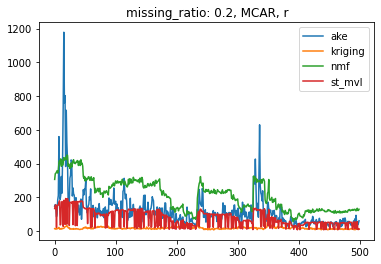

In [43]:
plt.figure()
plt.title('missing_ratio: {}, {}, {}'.format(tmp_result.missing_ratio,tmp_result.missing_pattern,tmp_result.missing_start_p))
# plt.plot(np.array(tmp_result.ake_loss)/(19*7),label='ake')
# plt.plot(np.array(tmp_result.kriging_loss)/(19*7),label='kriging')
# plt.plot(np.array(tmp_result.nmf_loss)/(19*7),label='nmf')
# plt.plot(np.array(tmp_result.st_mvl_loss)/(19*7),label='st_mvl')
plt.plot(np.array(tmp_result.ake_loss),label='ake')
plt.plot(np.array(tmp_result.kriging_loss),label='kriging')
plt.plot(np.array(tmp_result.nmf_loss),label='nmf')
plt.plot(np.array(tmp_result.st_mvl_loss),label='st_mvl')
plt.legend()